# Load the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Get each sheet

In [ ]:
sales_df = pd.read_excel('/content/Regional Sales Dataset.xlsx', sheet_name = 'Sales Orders')
cust_df = pd.read_excel('/content/Regional Sales Dataset.xlsx', sheet_name = 'Customers')
regions_df = pd.read_excel('/content/Regional Sales Dataset.xlsx', sheet_name = 'Regions')
states_df = pd.read_excel('/content/Regional Sales Dataset.xlsx', sheet_name = 'State Regions', header=1) #ignores the extra column at the top
products_df = pd.read_excel('/content/Regional Sales Dataset.xlsx', sheet_name = 'Products')
budget17_df = pd.read_excel('/content/Regional Sales Dataset.xlsx', sheet_name = '2017 Budgets')

Merge all the sheets into one dataframe based on whatever index matches

In [ ]:
df = (sales_df.merge(cust_df, left_on='Customer Name Index', right_on='Customer Index')
           .merge(regions_df, left_on='Delivery Region Index', right_on='id')
           .merge(states_df, left_on='state_code', right_on='State Code')
           .merge(products_df, left_on='Product Description Index', right_on='Index')
           .merge(budget17_df, left_on='Product Name', right_on='Product Name'))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64104 entries, 0 to 64103
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   OrderNumber                64104 non-null  object        
 1   OrderDate                  64104 non-null  datetime64[ns]
 2   Customer Name Index        64104 non-null  int64         
 3   Channel                    64104 non-null  object        
 4   Currency Code              64104 non-null  object        
 5   Warehouse Code             64104 non-null  object        
 6   Delivery Region Index      64104 non-null  int64         
 7   Product Description Index  64104 non-null  int64         
 8   Order Quantity             64104 non-null  int64         
 9   Unit Price                 64104 non-null  float64       
 10  Line Total                 64104 non-null  float64       
 11  Total Unit Cost            64104 non-null  float64       
 12  Cust

Remove a lot of the unneeded columns

In [ ]:
columns_to_drop = ['OrderNumber','county','population','households','time_zone','median_income','longitude','latitude','area_code','land_area','water_area', 'Customer Name Index', 'Delivery Region Index', 'Product Description Index', 'Customer Index', 'id', 'state_code', 'State Code', 'State', 'Index']
df = df.drop(columns=columns_to_drop, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64104 entries, 0 to 64103
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OrderDate        64104 non-null  datetime64[ns]
 1   Channel          64104 non-null  object        
 2   Currency Code    64104 non-null  object        
 3   Warehouse Code   64104 non-null  object        
 4   Order Quantity   64104 non-null  int64         
 5   Unit Price       64104 non-null  float64       
 6   Line Total       64104 non-null  float64       
 7   Total Unit Cost  64104 non-null  float64       
 8   Customer Names   64104 non-null  object        
 9   name             64104 non-null  object        
 10  state            64104 non-null  object        
 11  type             64104 non-null  object        
 12  Region           64104 non-null  object        
 13  Product Name     64104 non-null  object        
 14  2017 Budgets     64104 non-null  float

In [ ]:
df['Currency Code'].value_counts()

,count
Currency Code,
USD,64104


All of the orders are in the same currency so we can remove them.

In [ ]:
df = df.drop(columns='Currency Code', axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64104 entries, 0 to 64103
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OrderDate        64104 non-null  datetime64[ns]
 1   Channel          64104 non-null  object        
 2   Warehouse Code   64104 non-null  object        
 3   Order Quantity   64104 non-null  int64         
 4   Unit Price       64104 non-null  float64       
 5   Line Total       64104 non-null  float64       
 6   Total Unit Cost  64104 non-null  float64       
 7   Customer Names   64104 non-null  object        
 8   name             64104 non-null  object        
 9   state            64104 non-null  object        
 10  type             64104 non-null  object        
 11  Region           64104 non-null  object        
 12  Product Name     64104 non-null  object        
 13  2017 Budgets     64104 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int6

I want to rename the columns to make it easier to analyse.

In [ ]:
rename_dict = {
    'Warehouse Code': 'WarehouseCode',
    'Order Quantity': 'OrderQuantity',
    'Unit Price': 'UnitPrice',
    'Line Total': 'LineTotal',
    'Total Unit Cost': 'TotalUnitCost',
    'Customer Names': 'CustomerName',
    'name': 'PlaceName',
    'county': 'County',
    'state': 'State',
    'type': 'PlaceType',
    'Product Name': 'ProductName',
    '2017 Budgets': '2017Budgets'
}
df = df.rename(columns=rename_dict)

I need to add a Profit column to the data

In [26]:
df['Profit'] = df['LineTotal'] - (df['TotalUnitCost'] * df['OrderQuantity'])

I am going to split the dates into categorical Quarters.

In [27]:
bins = [0, 3, 6, 9, 12]
labels = ['Q1', 'Q2', 'Q3', 'Q4']
df['Quarter'] = pd.cut(df['OrderDate'].dt.month, bins=bins, labels=labels, include_lowest=True)

##Exploratory Data Analysis

Lets look at the revenue and profit for each area.

In [28]:
regional_performance = df.groupby('Region').agg({
    'LineTotal': ['sum', 'mean'],
    'Profit': ['sum', 'mean'],
    'OrderQuantity': 'sum'
}).reset_index()

# Flatten column names
regional_performance.columns = ['Region', 'Total_Revenue', 'Avg_Revenue', 'Total_Profit', 'Avg_Profit', 'Total_Quantity']

print(regional_performance)

      Region  Total_Revenue   Avg_Revenue  Total_Profit   Avg_Profit  \
0    Midwest    308316740.8  19318.091529  1.155351e+08  7239.040243   
1  Northeast    199854856.1  19534.244561  7.406783e+07  7239.549251   
2      South    321673157.3  19335.967618  1.201911e+08  7224.758837   
3       West    357994192.3  19043.257210  1.341243e+08  7134.651703   

   Total_Quantity  
0          134684  
1           86471  
2          140358  
3          158554  


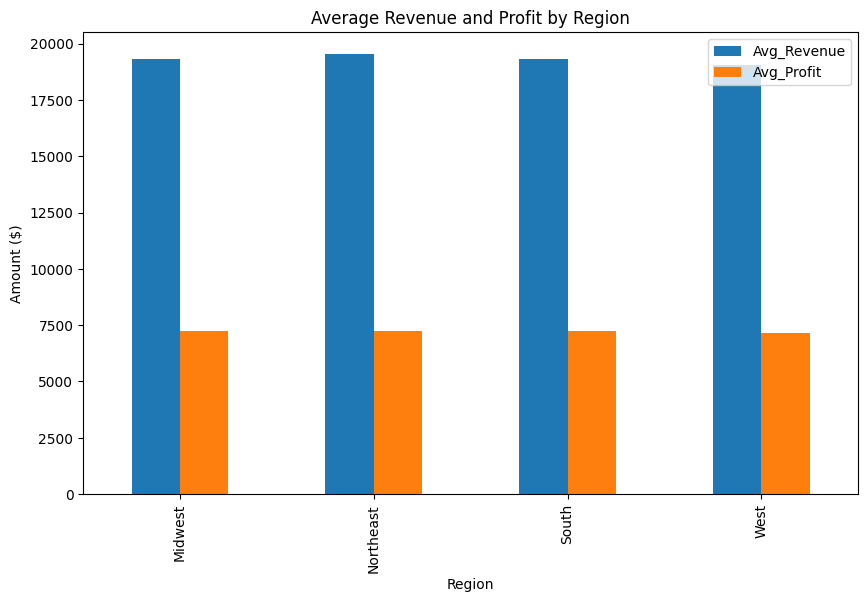

In [53]:
regional_performance.plot(x='Region', y=['Avg_Revenue', 'Avg_Profit'], kind='bar', figsize=(10, 6))
plt.title('Average Revenue and Profit by Region')
plt.ylabel('Amount ($)')
plt.show()

Quite clearly they are charging the same price in each region and making the same profit on each item.

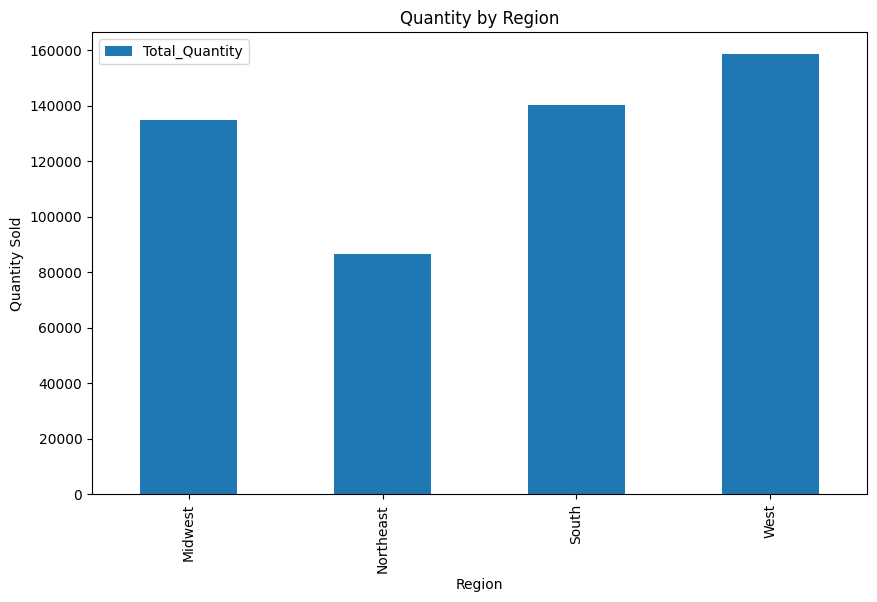

In [30]:
regional_performance.plot(x='Region', y='Total_Quantity', kind='bar', figsize=(10, 6))
plt.title('Quantity by Region')
plt.ylabel('Quantity Sold')
plt.show()

# Insight 1: West Region sells the most and Northeast Region sells the least.

As you can see they must be more orders made in the West and the least amount of orders coming from the Northeast.

Now lets have a look at how the profit is changing over time

In [31]:
df['Year'] = df['OrderDate'].dt.year

seasonal_trends = df.groupby(['Year', 'Quarter'],observed=True).agg({
    'LineTotal': 'sum',
    'Profit': 'sum'
}).reset_index()

#Taking out 2018 as there isn't much data
seasonal_trends = seasonal_trends[seasonal_trends['Year'] < 2018]

# Create a date column for plotting
seasonal_trends['Date'] = seasonal_trends['Year'].astype(str) + '-' + seasonal_trends['Quarter'].astype(str)

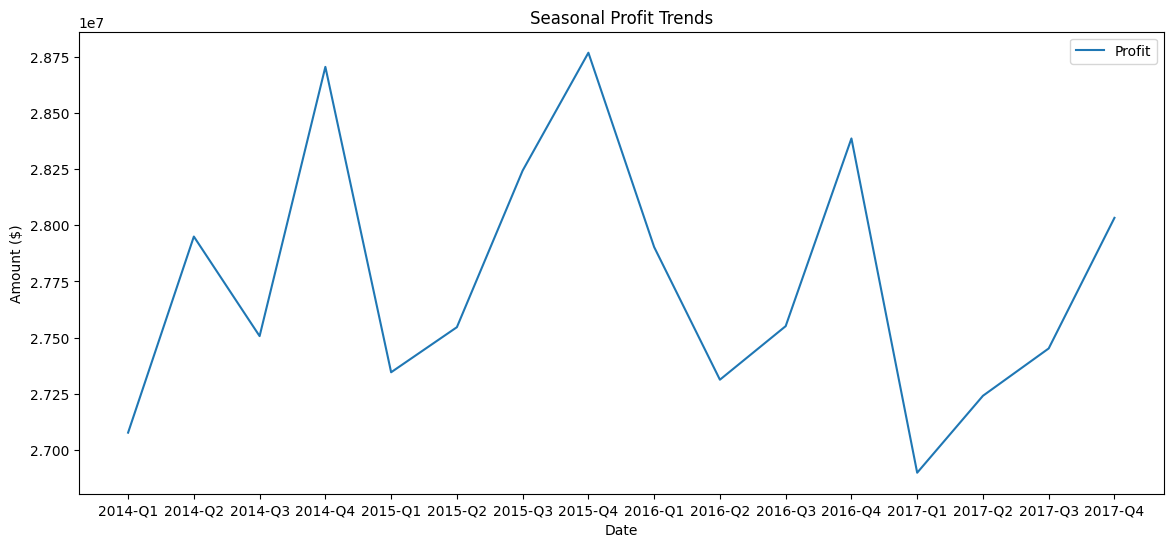

In [32]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Profit', data=seasonal_trends, label='Profit')
plt.title('Seasonal Profit Trends')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.legend()
plt.show()

# Insight 2: Profit increases throughout the year. Quarter 4 being the most and quarter 1 being the least.

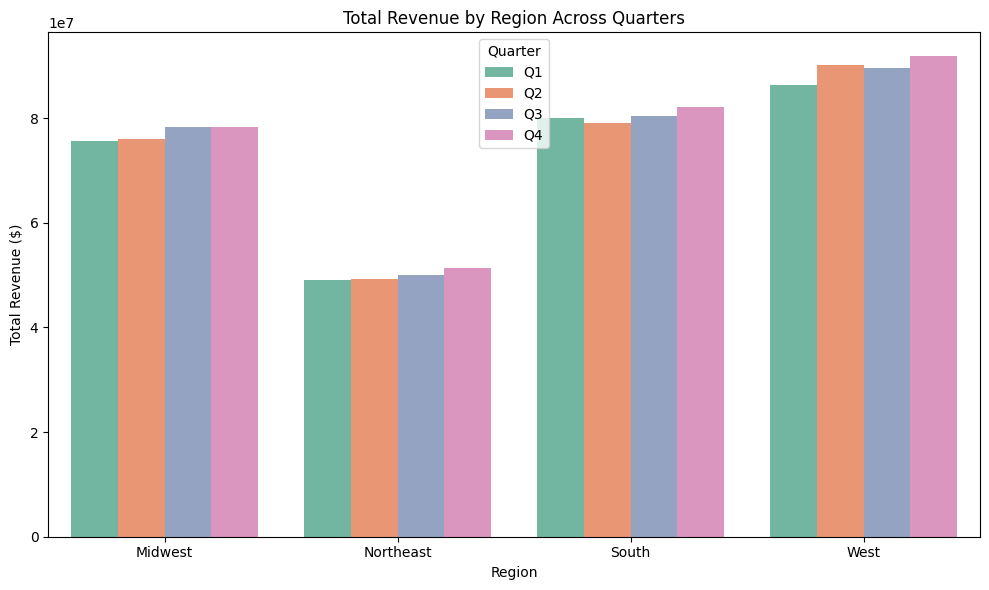

In [33]:
# Aggregate Line Total by Quarter and Region
df = df[df['Year'] < 2018] #Removed 2018 as there isn't equal data
regional_quarterly = df.groupby(['Region', 'Quarter'], observed=False)['LineTotal'].sum().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=regional_quarterly, x='Region', y='LineTotal', hue='Quarter', palette='Set2')

# Customize the plot
plt.title('Total Revenue by Region Across Quarters')
plt.xlabel('Region')
plt.ylabel('Total Revenue ($)')
plt.legend(title='Quarter')

plt.tight_layout()
plt.show()

The seasonal trend is pretty much the case in every region. Quarter 1 in the south is a slight anomoly.

Lets explore the highest earning products.

In [48]:
top_skus = df.groupby('ProductName').agg({
    'LineTotal': 'sum',
    'Profit': 'sum',
    'OrderQuantity': 'sum',
    '2017Budgets': 'mean'
}).sort_values('Profit', ascending=False).head(10)

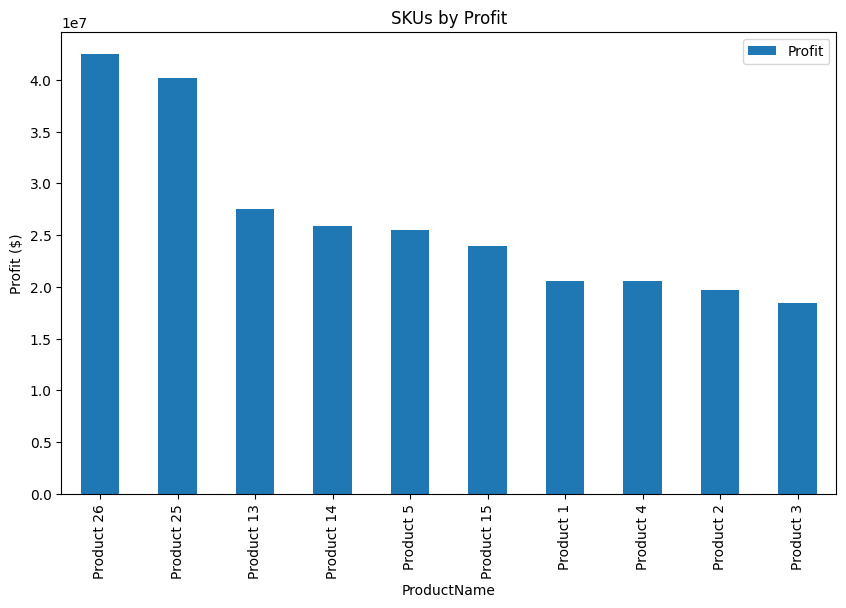

In [49]:
top_skus.plot(y='Profit', kind='bar', figsize=(10, 6))
plt.title('SKUs by Profit')
plt.ylabel('Profit ($)')
plt.show()

# Insight 3: Product 26 and 25 earn the most profit.

I am going to explore of the profit varies by Channel

In [36]:
channel_performance = df.groupby('Channel').agg({
    'LineTotal': 'sum',
    'Profit': 'sum'
}).reset_index()

channel_performance['Profit_Margin'] = (channel_performance['Profit'] / channel_performance['LineTotal']) * 100

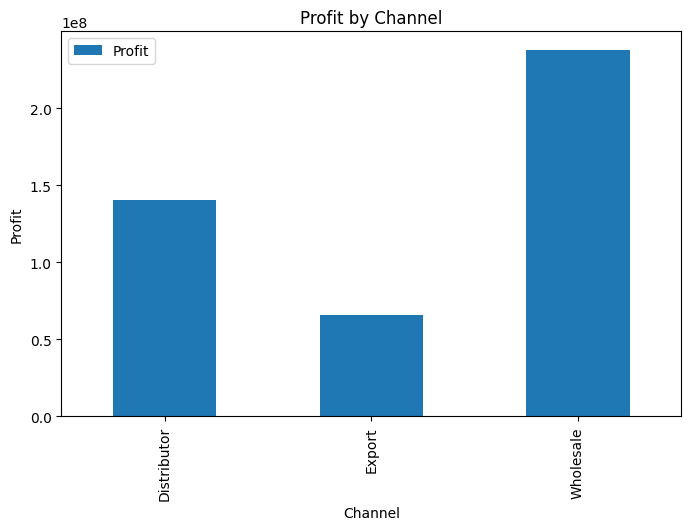

In [59]:
channel_performance.plot(x='Channel', y='Profit', kind='bar', figsize=(8, 5))
plt.title('Profit by Channel')
plt.ylabel('Profit')
plt.show()

# Insight 4: The profit is largely coming from wholesale orders.